# Маркетинг.

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

Цель - предсказать вероятность покупки в течение 90 дней.

**Описание данных.**

Нам предоставлены файлы:
- `apparel-purchases`
- `apparel-messages`
- `apparel-target_binary`
- `full_campaign_daily_event`
- `full_campaign_daily_event_channel`

Файл `apparel-purchases` содержит данные о покупках клиентов по дням и по товарам. В каждой записи покупка определенного товара, его цена, количество штук.

- `client_id` - идентификатор клиента
- `quantity` - количество единиц товара
- `price` - цена товара
- `category_ids` - идентификаторы категорий
- `date` - дата покупки
- `message_id` - идентификатор сообщения из рассылки

Файл `apparel-messages` содержит рассылки, которые были отправлены клиентам из таблицы покупок.

- `bulk_campaign_id` - идентификатор рассылки
- `client_id` - идентификатор клиента
- `message_id` - идентификатор сообщения
- `event` - действие с сообщением (отправлено, открыто, покупка...)
- `channel` - канал рассылки
- `date` - дата действия
- `created_at` - дата-время полностью

Файл `apparel-target_binary` содержит инфофрмацию с целевым признаком - совершит ли клиент покупку в течение следующих 90 дней.

- `client_id` - идентификатор пользователя
- `target` - целевой признак

Файл `full_campaign_daily_event` содержит агрегацию общей базы рассылок по дням и типам событий.

- `date` - дата
- `bulk_campaign_id` - идентификатор рассылки
- `count_event` - общее количество каждого события event
- `nunique_event` - количество уникальных client_id в каждом событии

Файл `full_campaign_daily_event_channel` содержит агрегацию по дням с учетом событий и каналов рассылки.

- `date` - дата
- `bulk_campaign_id` - идентификатор рассылки
- `count_event_channel` - общее количество каждого события по каналам
- `nunique_event_channel` - количество уникальных client_id по событиям и каналам

**План проведения исследования:**

- изучим данные
- проведём предобработку
- проведем исследовательский анализ данных
- создадим новые признаки
- создадим несколько моделей для классификации и выберем лучшую из них
- качество модели оценим метрикой ROC-AUC
- сформулируем выводы



### Загрузка и обзор данных.

Импортируем библиотеки.

In [125]:
pip install phik -q

In [126]:
pip install optuna -q

In [127]:
pip install optuna-integration -q

In [130]:
pip install shap -q

In [131]:
 pip install -U ydata-profiling -q

In [132]:
pip install catboost -q

In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import phik
import warnings
import math
import shap
import re

from ydata_profiling import ProfileReport

from phik.report import plot_correlation_matrix

from optuna import distributions
from optuna.integration import OptunaSearchCV

from catboost import CatBoostClassifier, cv, Pool

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score
)

pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(12, 6)})

RANDOM_STATE = 42
TEST_SIZE = 0.25

Считаем данные и запишем их в переменные.

In [134]:
purchases = pd.read_csv('/content/drive/MyDrive/DS/marketing/apparel-purchases.csv', sep=',')
messages = pd.read_csv('/content/drive/MyDrive/DS/marketing/apparel-messages.csv', sep=',')
target = pd.read_csv('/content/drive/MyDrive/DS/marketing/apparel-target_binary.csv')
daily_event = pd.read_csv('/content/drive/MyDrive/DS/marketing/full_campaign_daily_event.csv', sep=',')
daily_event_channel = pd.read_csv('/content/drive/MyDrive/DS/marketing/full_campaign_daily_event_channel.csv', sep=',')


#### Обзор данных.

Выведем на экран первые строки таблицы `purchases`.

In [135]:
purchases.head(10)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,"1,999.00","['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,"2,499.00","['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,"6,499.00","['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,"4,999.00","['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,"4,999.00","['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
5,1515915625471640575,1,"3,499.00","['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3
6,1515915625490211585,1,"1,699.00","['2', '18', '341', '1311']",2022-05-16,1515915625490211585-4301-627b661843283
7,1515915625490739153,1,"1,999.00","['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b
8,1515915625491478747,1,999.00,"['5562', '5631', '5549', '667']",2022-05-16,1515915625491478747-4273-6274ceb769d59
9,1515915625491651493,1,699.00,"['5562', '5630', '5649', '678']",2022-05-16,1515915625491651493-4437-6282242f2a9e2


Выведем основную информацию о датафрейме с помощью метода `info()` и проверим полноту имеющихся данных.

In [136]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


Таблица `purchases` содержит данные о покупках клиентов по дням и по товарам. В таблице 202,208 строки и 6 столбцов. Пропущенных значений нет. Необходимо изменить тип данных в столбце `date` на `datetime`.

Выведем на экран первые строки таблицы `messages`.

In [137]:
messages.head(10)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52
5,4439,1515915625594606468,1515915625594606468-4439-6283411f277fc,open,email,2022-05-19,2022-05-19 01:04:11
6,4439,1515915625491810918,1515915625491810918-4439-6283411d9d299,open,email,2022-05-19,2022-05-19 01:19:54
7,4439,1515915625474219766,1515915625474219766-4439-628341212233a,open,email,2022-05-19,2022-05-19 01:23:43
8,4439,1515915625474219766,1515915625474219766-4439-628341212233a,click,email,2022-05-19,2022-05-19 01:24:16
9,4439,1515915625566741491,1515915625566741491-4439-6283412871599,open,email,2022-05-19,2022-05-19 01:31:06


Выведем основную информацию о датафрейме с помощью метода `info()` и проверим полноту имеющихся данных.

In [138]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


Таблица `messages` содержит данные о рассылках, которые были отправлены клиентам из таблицы покупок. Пропущенных значений нет. Необходимо изменить тип данных в столбцах `date` и `created_at` на `datetime`. В таблице 12,739,798 строк и 7 столбцов.

Выведем на экран первые строки таблицы `target`.

In [139]:
target.head(10)

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0
5,1515915625468061514,0
6,1515915625468061877,0
7,1515915625468061975,0
8,1515915625468061994,0
9,1515915625468062158,0


Выведем основную информацию о датафрейме с помощью метода `info()` и проверим полноту имеющихся данных.

In [140]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


Таблица `target` содержит целевой признак - совершит ли клиент покупку в течение следующих 90 дней. Пропущенных значений нет. В таблице 49,849 строк.

Выведем на экран первые строки таблицы `daily_event`.

In [141]:
daily_event.head(10)

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,nunique_click,nunique_complain,nunique_hard_bounce,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5,2022-05-19,764,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
6,2022-05-19,766,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
7,2022-05-19,783,1,0,0,8,0,0,0,0,0,1,0,0,6,0,0,0,0,0,0,0,0,0
8,2022-05-19,817,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
9,2022-05-19,833,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


Выведем основную информацию о датафрейме с помощью метода `info()` и проверим полноту имеющихся данных.

In [142]:
daily_event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  int64 
 15  nunique_purchase     131072 non-nu

Таблица `daily_event` содержит агрегацию общей базы рассылок по дням и типам событий. Пропущенных значений нет. Тип данных в столбце `date` необходимо изменить на `datetime`. В таблице 131,072 строк и 24 столбца.

Выведем на экран первые строки таблицы `daily_event_channel`.

In [143]:
daily_event_channel.head(10)

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,nunique_click_email,nunique_click_mobile_push,nunique_open_email,nunique_open_mobile_push,nunique_purchase_email,nunique_purchase_mobile_push,nunique_soft_bounce_email,nunique_subscribe_email,nunique_unsubscribe_email,count_hard_bounce_mobile_push,count_send_mobile_push,nunique_hard_bounce_mobile_push,nunique_send_mobile_push,count_hard_bounce_email,count_hbq_spam_email,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2022-05-19,764,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,2022-05-19,766,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,2022-05-19,783,1,0,8,0,0,0,0,0,0,1,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,2022-05-19,817,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,2022-05-19,833,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Выведем основную информацию о датафрейме с помощью метода `info()` и проверим полноту имеющихся данных.

In [144]:
daily_event_channel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click_email              131072 non-null  int64 
 12  nunique_click_mo

Таблица `daily_event_channel` содержит агрегацию по дням с учетом событий и каналов рассылки. Пропущенных значений нет. Тип данных в столбце `date` необходимо изменить на `datetime`. В таблице 131,072 строк и 36 столбцов.

#### Выводы:

Таблица `purchases` содержит данные о покупках клиентов по дням и по товарам. В таблице 202,208 строки и 6 столбцов. Пропущенных значений нет. Необходимо изменить тип данных в столбце `date` на `datetime`.

Таблица `messages` содержит данные о рассылках, которые были отправлены клиентам из таблицы покупок. Пропущенных значений нет. Необходимо изменить тип данных в столбцах `date` и `created_at` на `datetime`. В таблице 12,739,798 строк и 7 столбцов.

Таблица `target` содержит целевой признак - совершит ли клиент покупку в течение следующих 90 дней. Пропущенных значений нет. В таблице 49,849 строк.

Таблица `daily_event` содержит агрегацию общей базы рассылок по дням и типам событий. Пропущенных значений нет. Тип данных в столбце `date` необходимо изменить на `datetime`. В таблице 131,072 строк и 24 столбца.

Таблица `daily_event_channel` содержит агрегацию по дням с учетом событий и каналов рассылки. Пропущенных значений нет. Тип данных в столбце `date` необходимо изменить на `datetime`. В таблице 131,072 строк и 36 столбцов.



### Предобработка данных.

#### Тип данных.

Изучим типы данных в таблицах.

Проверим типы данных в таблице `purchases`.

In [145]:
purchases.dtypes

,0
client_id,int64
quantity,int64
price,float64
category_ids,object
date,object
message_id,object


Изменим тип данных в столбце `date`.

In [146]:
purchases['date'] = pd.to_datetime(purchases['date'])

Проверим результат.

In [147]:
purchases.dtypes

,0
client_id,int64
quantity,int64
price,float64
category_ids,object
date,datetime64[ns]
message_id,object


Тип данных успешно изменен.

Проверим типы данных в таблице `messages`.

In [148]:
messages.dtypes

,0
bulk_campaign_id,int64
client_id,int64
message_id,object
event,object
channel,object
date,object
created_at,object


Изменим тип данных в столбцах `date` и `created_at`.

In [149]:
messages['date'] = pd.to_datetime(messages['date'])
messages['created_at'] = pd.to_datetime(messages['created_at'])

Проверим результат.

In [150]:
messages.dtypes

,0
bulk_campaign_id,int64
client_id,int64
message_id,object
event,object
channel,object
date,datetime64[ns]
created_at,datetime64[ns]


Тип данных успешно изменен.

Проверим типы данных в таблице `daily_event`.

In [151]:
daily_event.dtypes

,0
date,object
bulk_campaign_id,int64
count_click,int64
count_complain,int64
count_hard_bounce,int64
count_open,int64
count_purchase,int64
count_send,int64
count_soft_bounce,int64
count_subscribe,int64


Изменим тип данных в столбце `date`.

In [152]:
daily_event['date'] = pd.to_datetime(daily_event['date'])

Проверим результат.

In [153]:
daily_event.dtypes

,0
date,datetime64[ns]
bulk_campaign_id,int64
count_click,int64
count_complain,int64
count_hard_bounce,int64
count_open,int64
count_purchase,int64
count_send,int64
count_soft_bounce,int64
count_subscribe,int64


Тип данных успешно изменен.

Проверим типы данных в таблице `daily_event_channel`.

In [154]:
daily_event_channel.dtypes

,0
date,object
bulk_campaign_id,int64
count_click_email,int64
count_click_mobile_push,int64
count_open_email,int64
count_open_mobile_push,int64
count_purchase_email,int64
count_purchase_mobile_push,int64
count_soft_bounce_email,int64
count_subscribe_email,int64


Изменим тип данных в столбце `date`.

In [155]:
daily_event_channel['date'] = pd.to_datetime(daily_event_channel['date'])

Тип данных успешно изменен.

#### Проверим наличие явных дубликатов.

Проверим явные дубликаты в таблице `purchases`.

In [156]:
purchases.duplicated().sum()

73020

Пока оставим дубликаты в таблице `purchases`, так как покупки могут дублироваться.

Проверим явные дубликаты в таблице `messages`.

In [157]:
messages.duplicated().sum()

48610

Удалим дубликаты.

In [158]:
messages = messages.drop_duplicates()

Проверим явные дубликаты в таблице `target`.

In [159]:
target.duplicated().sum()

0

Дубликаты не обнаружены.

Проверим явные дубликаты в таблице `daily_event`.

In [160]:
daily_event.duplicated().sum()

0

Дубликаты не обнаружены.

Проверим явные дубликаты в таблице `daily_event_channel`.

In [161]:
daily_event_channel.duplicated().sum()

0

Дубликаты не обнаружены.

#### Проверим наличие неявных дубликатов.

Удалим лишние символы в таблице `purchases` в столбце `category_ids`.

In [162]:
def remove_non_numberics(s):
    return re.sub('[^0-9]+', ' ', s)

purchases['category_ids'] = purchases['category_ids'].apply(remove_non_numberics)

Проверим результат.

In [163]:
purchases.sample(3)

,client_id,quantity,price,category_ids,date,message_id
35551,1515915625586599688,1,999.00,4 27 142 496,2022-09-01,1515915625586599688-6223-630c9088d2344
99816,1515915625758985171,1,"1,400.00",2 18 258 1569,2023-04-07,1515915625602623370-11608-642fdc9048348
66537,1515915625503317766,1,"1,049.00",5963 5959 6021 5978,2022-12-16,1515915625764150848-8722-639c1883d4a8b


Лишние символы успешно удалены. Проверим, образовались ли пробелы.

In [164]:
purchases[purchases['category_ids'] == ' ']['category_ids'].count()

6843

Заменим пробелы на заглушку `-999`.

In [165]:
purchases.loc[purchases['category_ids'] == ' ', 'category_ids'] = -999

Проверим результат.

In [166]:
purchases[purchases['category_ids'] == -999]['category_ids'].count()

6843

Данные успешно изменены.

Проверим неявные дубликаты в таблице `messages`.

purchases
messages
target
daily_event
daily_event_channel

In [167]:
messages['event'].unique()

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
      dtype=object)

In [168]:
messages['channel'].unique()

array(['email', 'mobile_push'], dtype=object)

Неявные дубликаты не обнаружены.

#### Проверим количественные значения в таблицах.

Провери количественные значения в таблице `purchases`.

In [169]:
purchases.drop(['client_id'], axis=1).describe()

,quantity,price,date
count,"202,208.00","202,208.00",202208
mean,1.01,"1,193.30",2023-03-17 02:49:35.739832064
min,1.00,1.00,2022-05-16 00:00:00
25%,1.00,352.00,2022-11-12 00:00:00
50%,1.00,987.00,2023-04-12 00:00:00
75%,1.00,"1,699.00",2023-07-03 00:00:00
max,30.00,"85,499.00",2024-02-16 00:00:00
std,0.18,"1,342.25",NaN


Явных выбросов не обнаружено, минимальное количество товаров - 1, максимальное - 30, минимальная цена - 1, максимальная 85.499. Данные о чеках доступны почти за два года с 2022-05-16 по 2024-02-16. Более детальную информацию получим на этапе исследовательского анализа данных.

#### Выводы:

Типы данных в столбцах были приведены в соответствии с их содержимым.

Проверены явные и неявные дубликаты.

При проверке количественных признаков явных выбросов не обнаружено, минимальное количество товаров - 1, максимальное - 30, минимальная цена - 1, максимальная 85.499. Данные о чеках доступны почти за два года с 2022-05-16 по 2024-02-16.

### Исследовательский анализ данных.

Напишем функцию для проверки количественных значений.

In [170]:
def check_quan(data, col, bins=20):
    display(data[col].describe())

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

    data[col].plot(kind='hist', bins=bins, ax=axes[0], grid=True)
    axes[0].set_title('Гистограмма распределения', fontsize=14)
    axes[0].set_ylabel('Частота встречаемости')
    axes[0].set_xlabel('Наблюдаемые значения')

    data[col].plot(kind='box', ax=axes[1], rot=0, grid=True)
    axes[1].set_title('Разброс значений признаков', fontsize=14)
    axes[1].set_xlabel('Категория')
    axes[1].set_ylabel('Наблюдаемые значения')
    plt.show()

Напишем функцию для проверки категориальных значений.

In [171]:
def check_cat(data, cat):

    ax = sns.countplot(x=data[cat],
                   order=data[cat].value_counts(ascending=False).index);

    abs_values = data[cat].value_counts(ascending=False).values

    ax.bar_label(container=ax.containers[0], labels=abs_values)
    ax.set_title('Распределение категорий признака ' + cat)
    ax.set(xlabel='Категории', ylabel='Частота встречаемости')
    ax.figure.set_size_inches(20,10);

Напишем функцию для проверки топ 10 категорий.

In [172]:
def check_cat_top(data, cat):

    filtered_data = data[data[cat] != -999]

    ax = sns.countplot(x=filtered_data[cat],
                   order=filtered_data[cat].value_counts(ascending=False).head(10).index);

    abs_values = filtered_data[cat].value_counts(ascending=False).head(10).values

    ax.bar_label(container=ax.containers[0], labels=abs_values)
    ax.set_title('Распределение категорий признака ' + cat)
    ax.set(xlabel='Категории', ylabel='Частота встречаемости')
    ax.figure.set_size_inches(20,10);

Напишем функцию для проверки временных признаков.

In [173]:
def check_date(data, cat):

    ax = sns.displot(data[cat].dt.strftime('%m.%Y')).set(title='Распределение значений признака ' + cat + ' по годам')

    ax.set(xlabel='Год', ylabel='Частота встречаемости')
    ax.figure.set_size_inches(22,6);

#### Изучим таблицу `purchases`.

Построим гистограмму распределения по признаку `quantity`.

,quantity
count,"202,208.00"
mean,1.01
std,0.18
min,1.00
25%,1.00
50%,1.00
75%,1.00
max,30.00


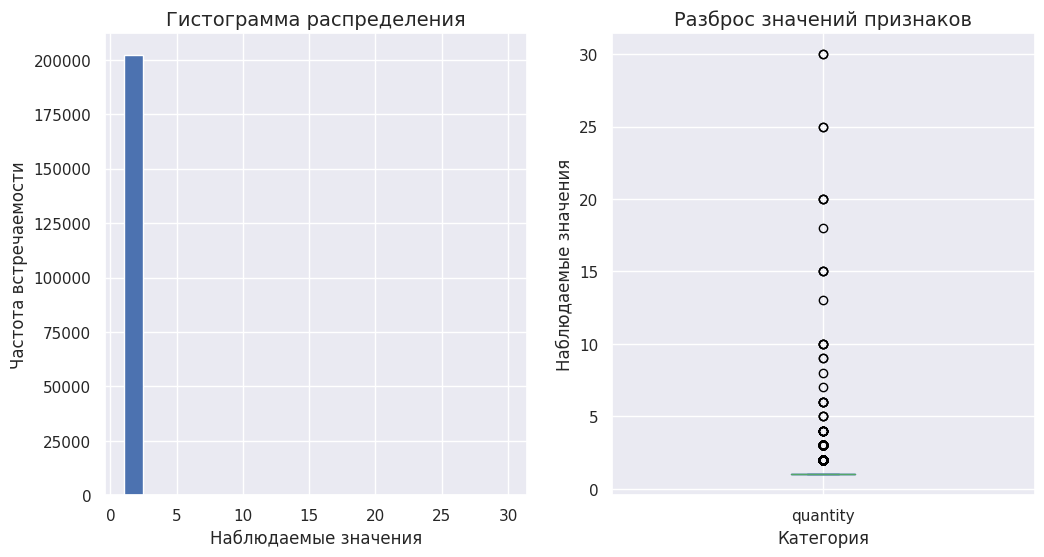

In [174]:
check_quan(purchases, 'quantity')

Большинство покупок было совершено в количестве 1 штуки. Размах значений от 1 до 30. Проверим количество покупок более 1.

In [175]:
purchases[purchases['quantity'] > 1]['quantity'].count()

885

Из 202,208 записей всего 885 покупок с количеством товара более одного.

Построим гистограмму распределения по признаку `price`.

,price
count,"202,208.00"
mean,"1,193.30"
std,"1,342.25"
min,1.00
25%,352.00
50%,987.00
75%,"1,699.00"
max,"85,499.00"


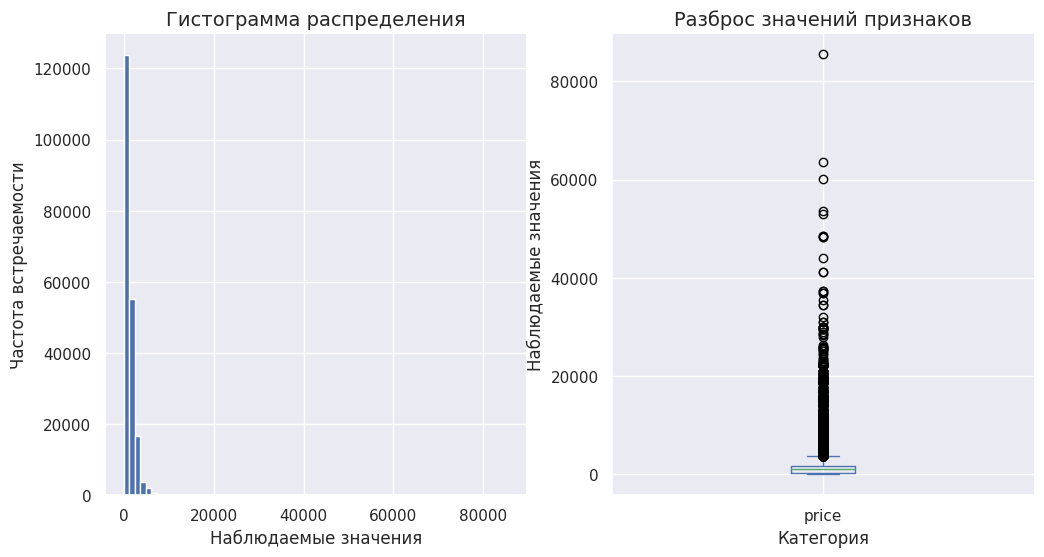

In [176]:
check_quan(purchases, 'price', bins=70)

Размах значений от 1 до 85,499. Суммы заказов в основном небольшие, примерно до 4,000. Построим новый график со значениями менее 5,000 и примем решение по удалению выбросов.

,price
count,"200,006.00"
mean,"1,116.68"
std,973.11
min,1.00
25%,349.00
50%,940.00
75%,"1,679.00"
max,"4,999.00"


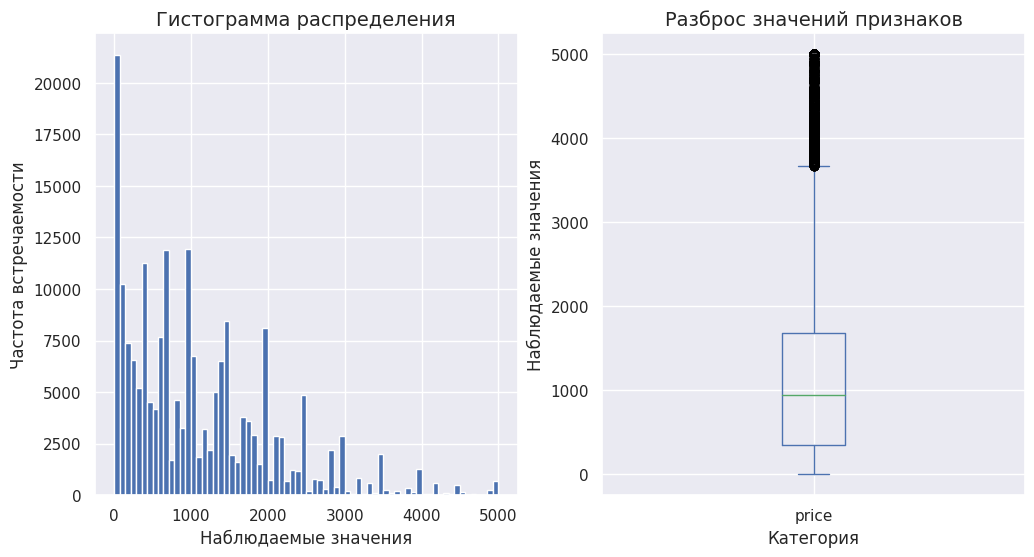

In [177]:
check_quan(purchases[purchases['price'] < 5001], 'price', bins=70)

На гистограмме мы видим нормально распределение с отклонением вправо. Есть пиковые значения из разряда 99, 999, 1999 и так далее, что вполне нормально при выставлении более привлекательной цены для покупателя. Из 201,323 изначальных значений осталось 199,133, что вполне нас утраивает. Оставим значения с ценой более 5,000.

Проверим категориальные значения в столбце `category_ids`.

In [178]:
purchases['category_ids'].nunique()

932

Так как категорий очень много, проверим только топ 10.

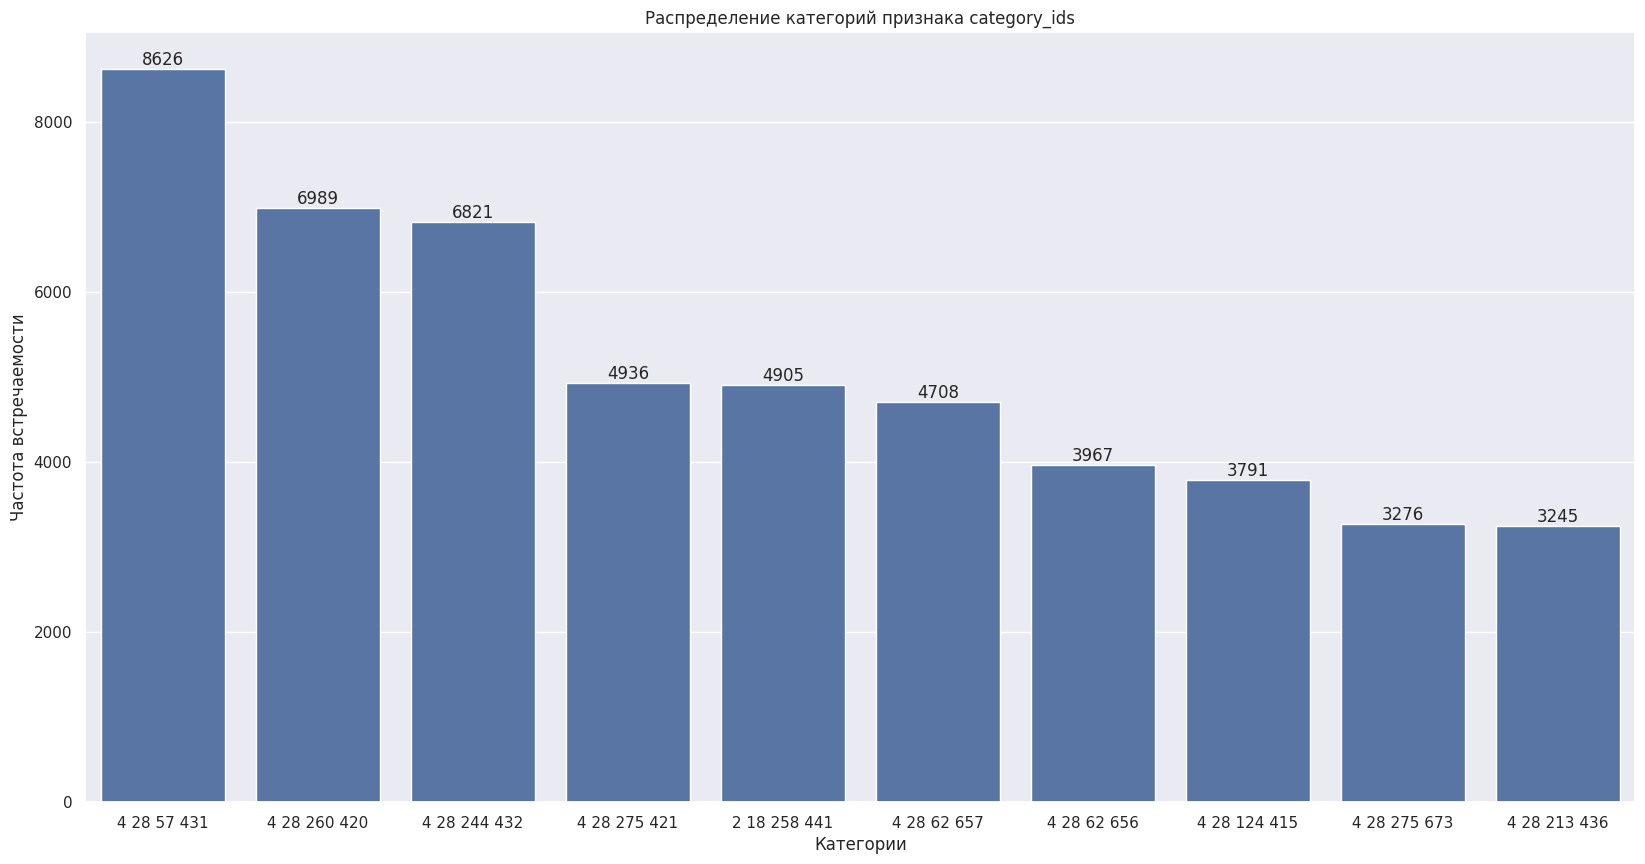

In [179]:
check_cat_top(purchases, 'category_ids')

Расшифровки категорий у нас нет, но на графике мы видим, что большинство позиций содержат категории: 4, 28.

Изучим временной признак `date`.

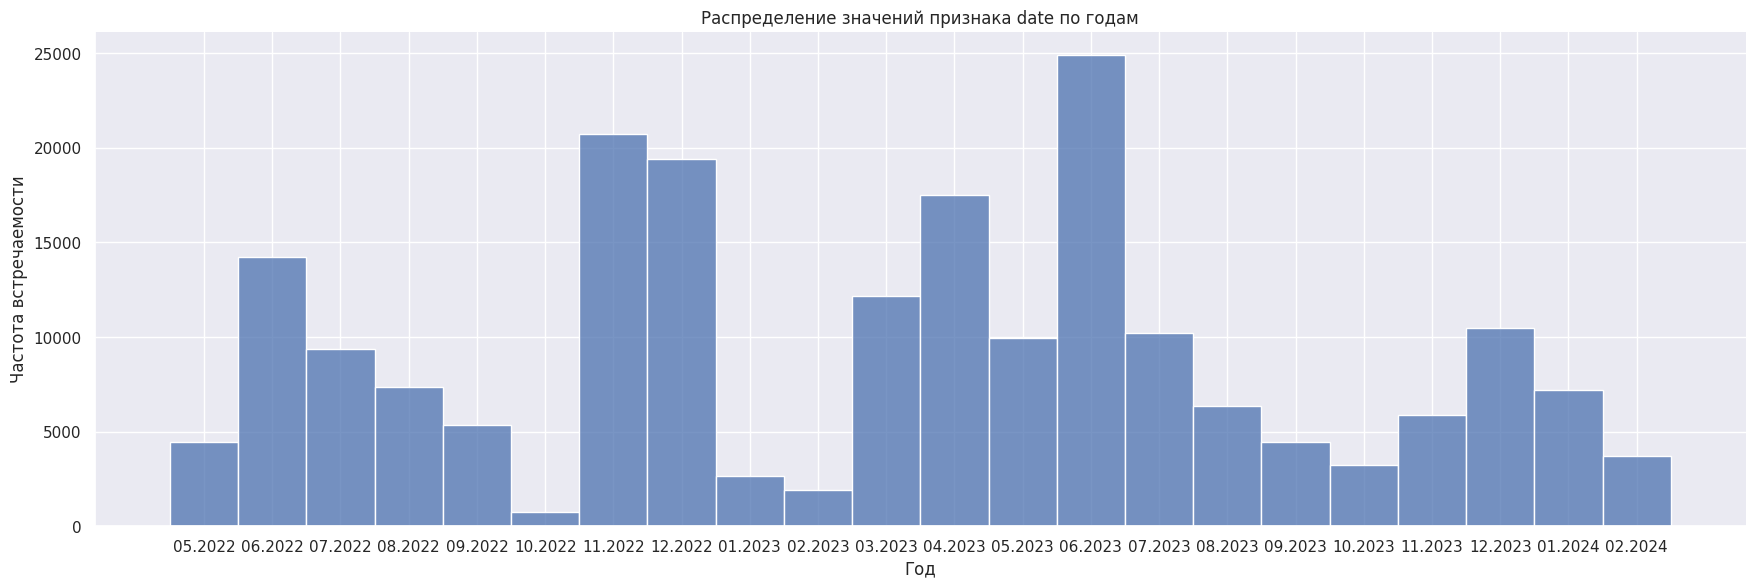

In [180]:
check_date(purchases, 'date')

На графике мы видим, что больше всего данных продаж за 2023 год, что логично, так как за 2022 и 2024 данные предоставлены не полностью. Также мы видим, что продажи непостоянны, есть большое количество продаж в летний период 06.2022 и 06.2023. В зимний период 11.2022 и 12.2022 был рост продаж, однако, в те же месяцы 2023 года продажы были значительно ниже.

#### Изучим таблицу `messages`.

In [181]:
messages.head(2)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34


Проверим категориальные значения в столбце `event`.

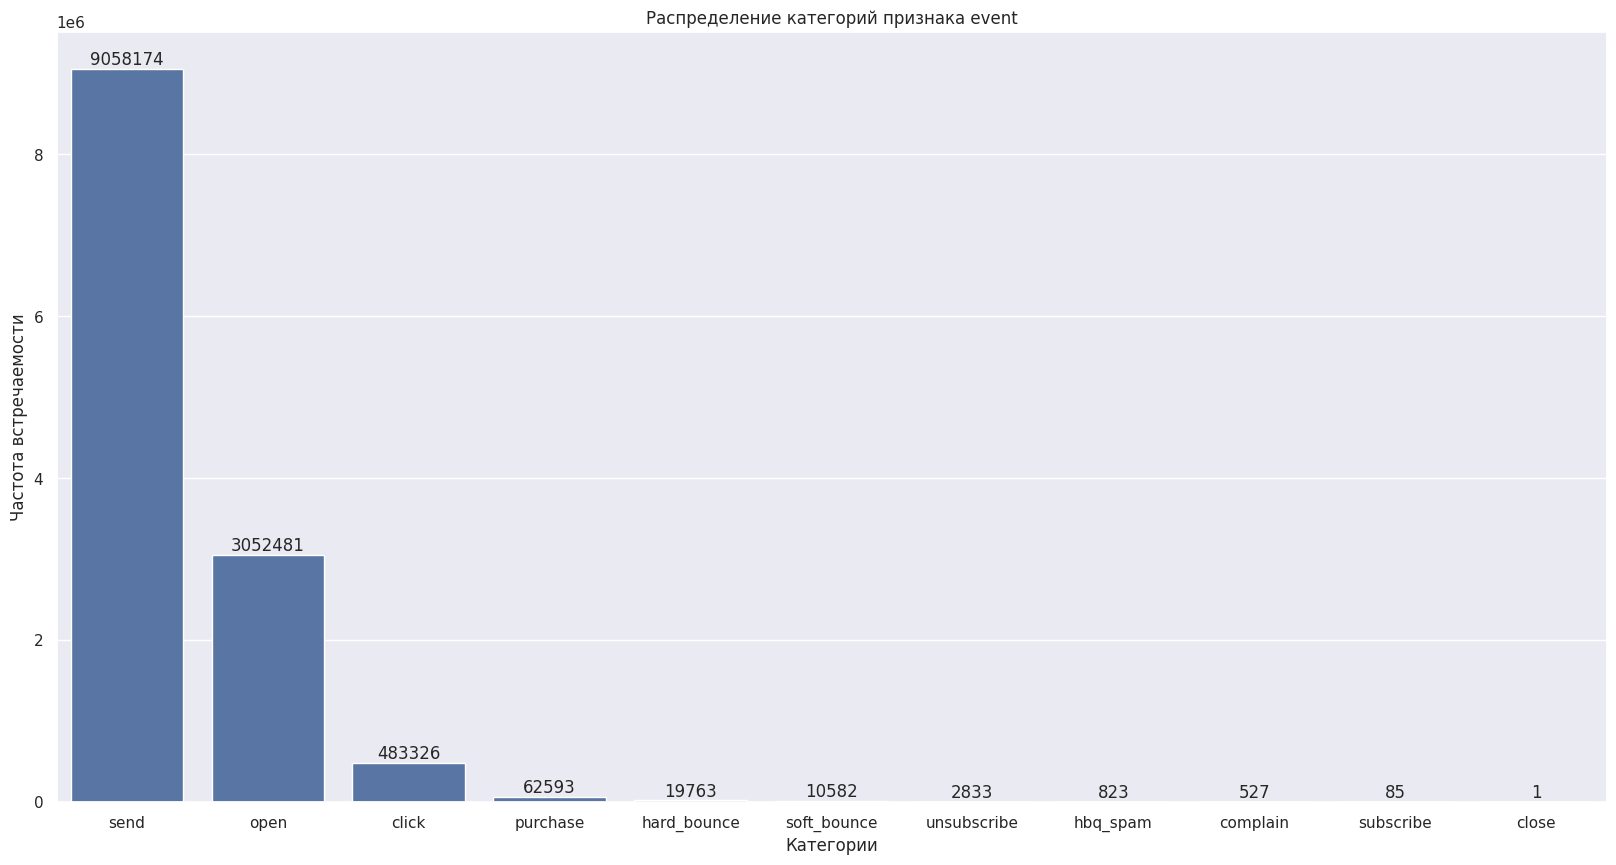

In [182]:
check_cat(messages, 'event')

На графике мы видим большое количество отправленных писем, более 9,000,000. Было открыто более 3,000,000. Перешли по ссылке более 480,000. Совершили покупку более 62,000. Можно сделать несколько категорий из данных признаков - "хорошую" с письмами, которые открыли, кликнули и совершили покупку, нейтральную категорию с письмами без действий, то есть которые просто отправили, и "плохую" категорию со всеми оставшимися категориями.


Проверим категориальные значения в столбце `channel`.

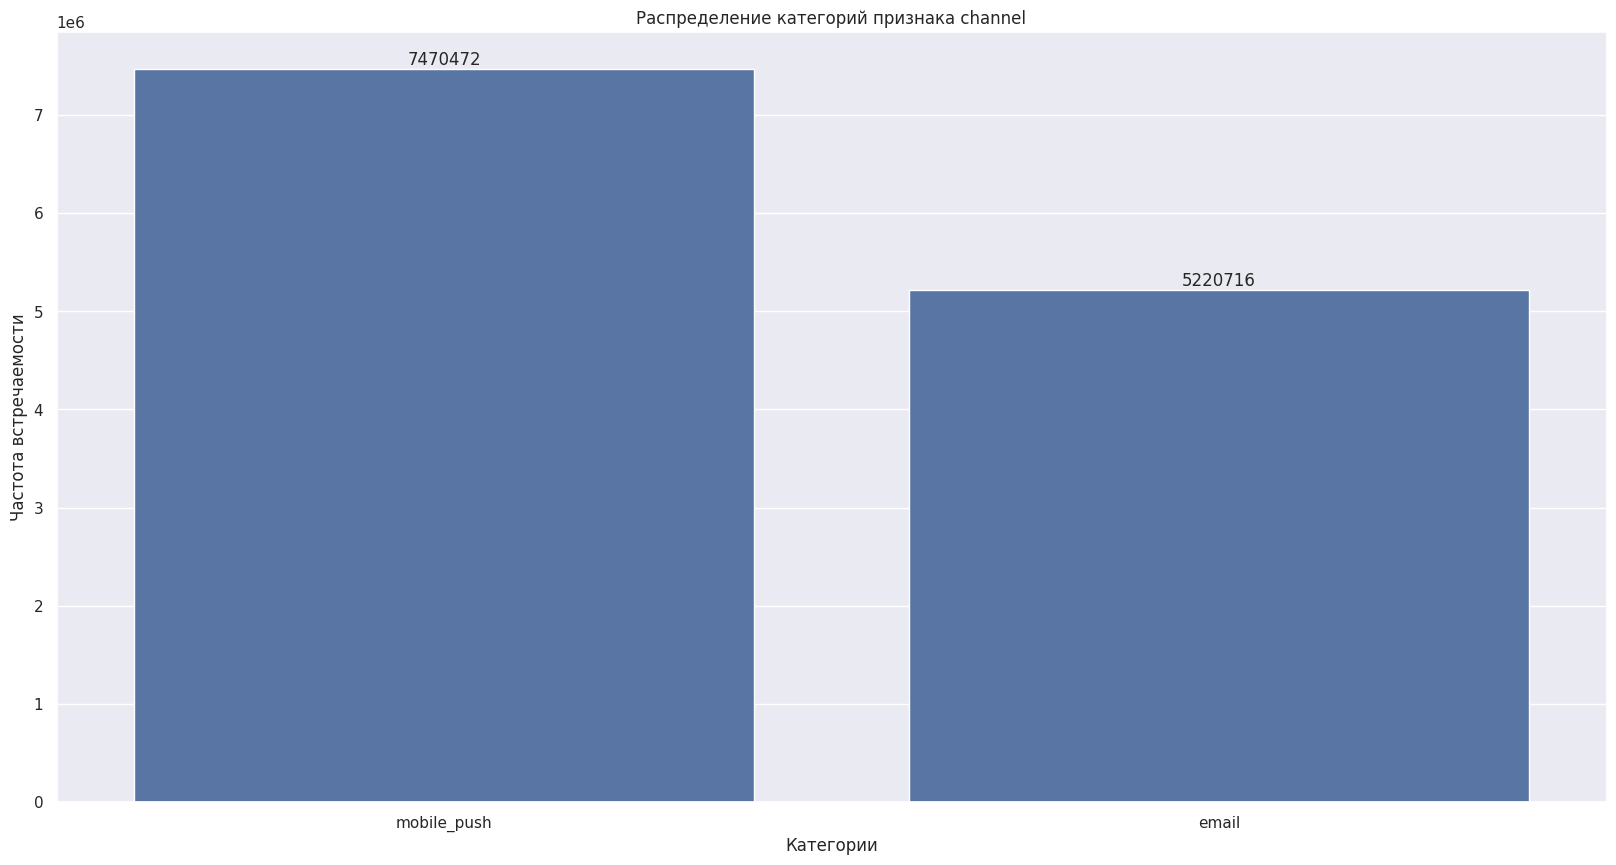

In [183]:
check_cat(messages, 'channel')

Чаще письма отправляются с помощью пуш уведомлений.

Проверим временные значения в столбце `date`.

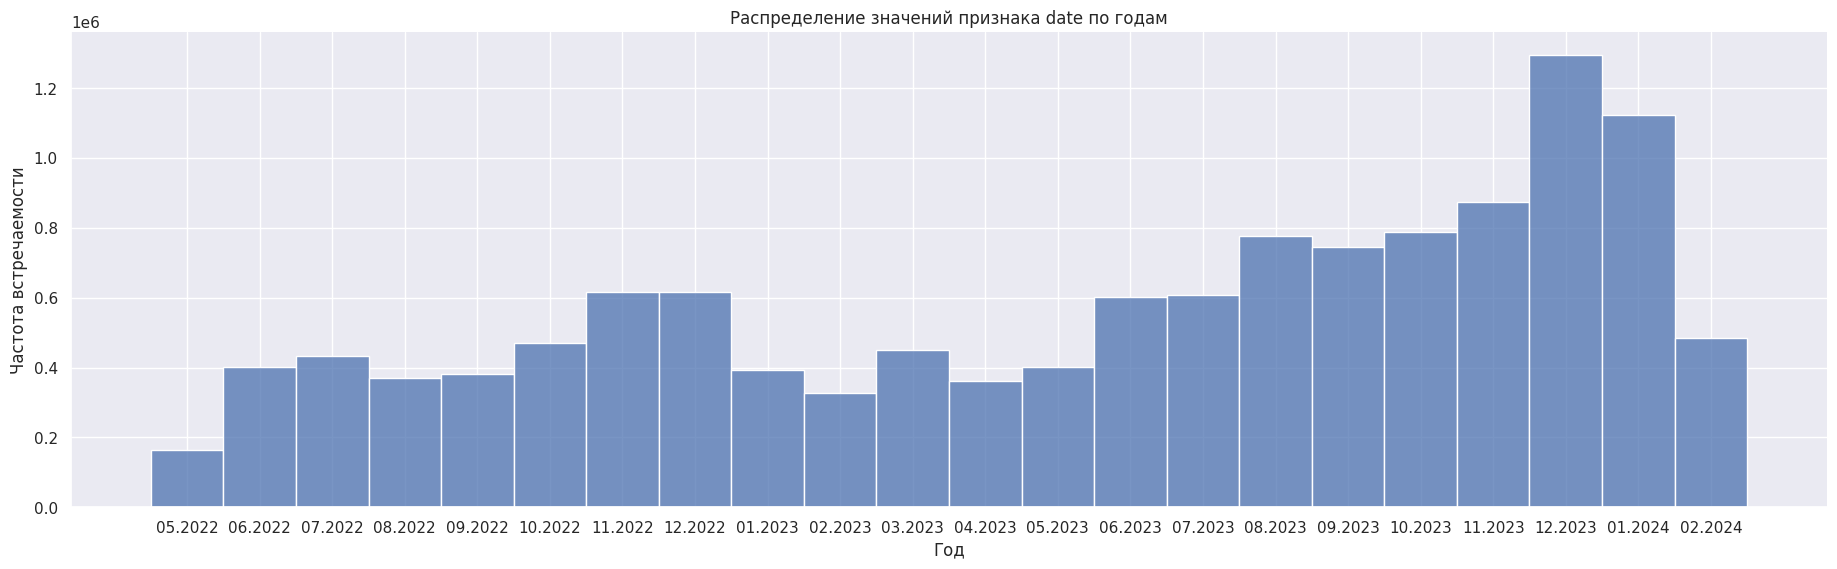

In [184]:
check_date(messages, 'date')

Количество рассылок сообщений по датам распределены равномерно. Есть небольшой рост отправки сообщений в конце года в 11 и 12 месяце.

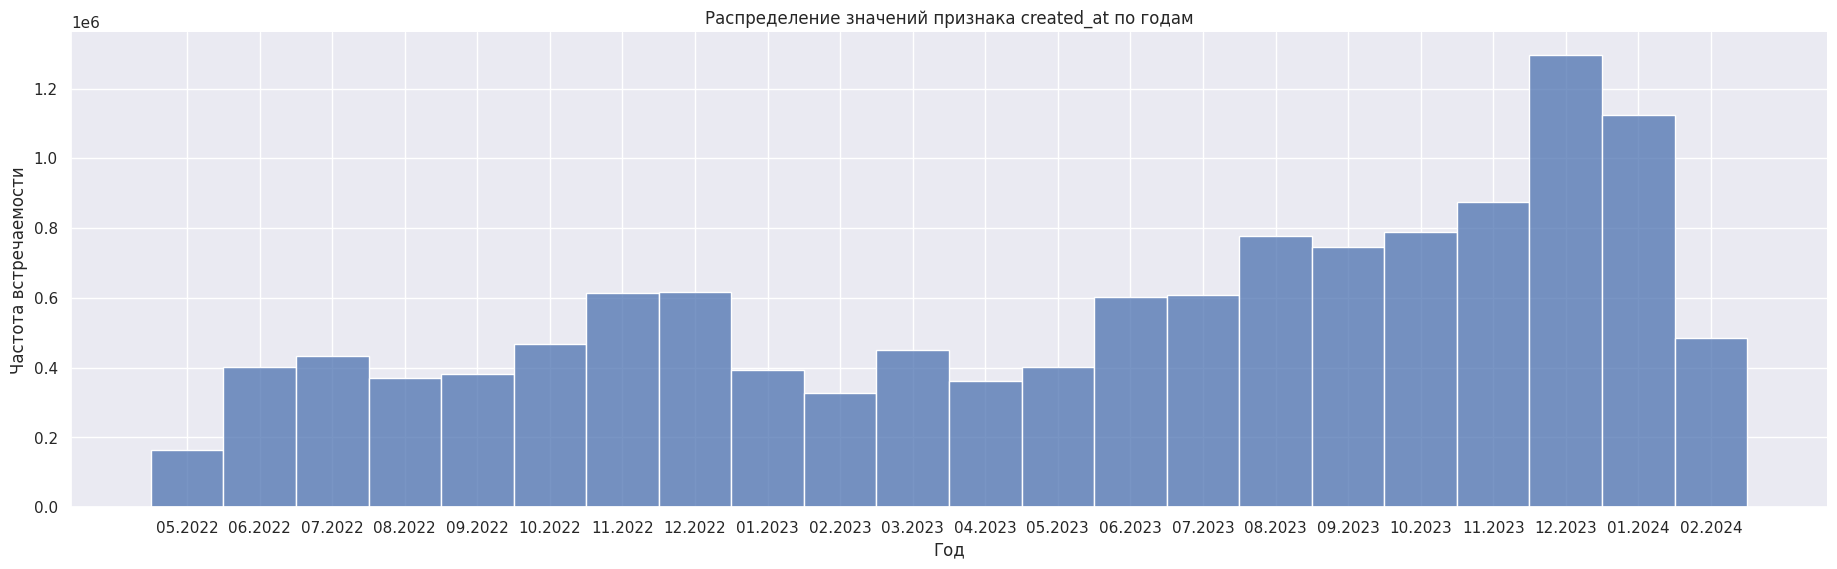

In [185]:
check_date(messages, 'created_at')

Дата созданий сообщений распределены также как и признак `date`.

#### Изучим таблицу `target`.

Проверим категориальные значения в столбце `target`.

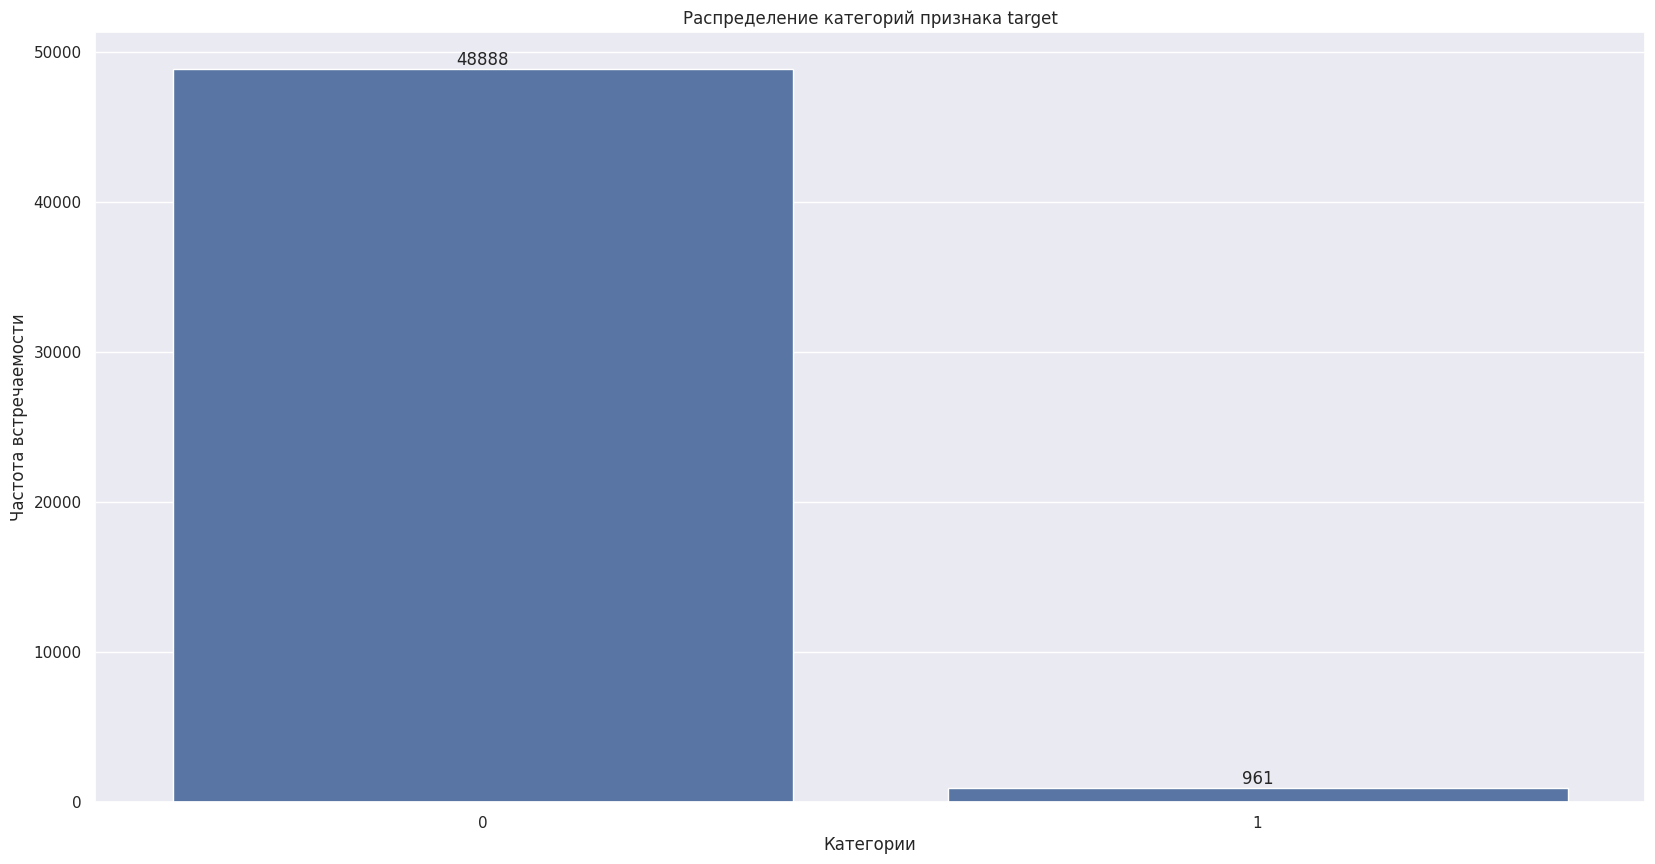

In [186]:
check_cat(target, 'target')

На графике мы видим дисбаланс классов, можно будет применить оверсэмплер.

In [187]:
#profile_daily_event = ProfileReport(daily_event, title="Pandas Profiling Report")

In [188]:
#profile_daily_event_channel = ProfileReport(daily_event_channel, title="Pandas Profiling Report")

#### Выводы:

- Таблица `purchases`

Большинство покупок было совершено в количестве 1 штуки. Размах значений от 1 до 30. Из 202,208 записей всего 885 покупок с количеством товара более одного.

Размах значений цен от 1 до 85,499. Суммы заказов в основном небольшие, примерно до 4,000. На гистограмме мы видим нормально распределение с отклонением вправо. Есть пиковые значения из разряда 99, 999, 1999 и так далее, что вполне нормально при выставлении более привлекательной цены для покупателя. Удалим выбросы с ценой более 5,000.

Большинство позиций в чеках содержат категории: 4, 28.

На графике с датами продаж мы обнаружили, что продажи непостоянны, есть большое количество продаж в летний период 06.2022 и 06.2023. В зимний период 11.2022 и 12.2022 был рост продаж, однако, в те же месяцы 2023 года продажы были значительно ниже.

- Таблица `messages`

На графике маркетинговой активности мы видим большое количество отправленных писем, более 9,000,000. Было открыто более 3,000,000. Перешли по ссылке более 480,000. Совершили покупку более 62,000. Можно сделать несколько категорий из данных признаков - "хорошую" с письмами, которые открыли, кликнули и совершили покупку, нейтральную категорию с письмами без действий, то есть которые просто отправили, и "плохую" категорию со всеми оставшимися категориями.

Чаще сообщения отправляются с помощью пуш уведомлений.

Количество рассылок сообщений по датам распределены равномерно. Есть небольшой рост отправки сообщений в конце года в 11 и 12 месяце.

- Таблица `target`

Был обнаружен дисбаланс классов, 98% данных с признаком 0, 2% с признаком 1. Можно будет применить оверсэмплер.

### Объеденение таблиц и создание новых признаков.

Создадим признак `last_purchase_date` и `first_purchase_date`, в котором будут данные с количеством прошедших дней от последней покупи. Для этого вычтем дату выгрузки таблицы из `date`. Столбец `first_purchase_date` аналогичен `last_purchase_date`, он нам понадобится в дальнейшем для агригации.

In [189]:
purchases['date'].max()

Timestamp('2024-02-16 00:00:00')

In [190]:
purchases['last_purchase_date'] = (pd.to_datetime('2024-02-16') - purchases['date']).dt.days
purchases['first_purchase_date'] = purchases['last_purchase_date']

В столбце `client_message_id` содержится информация о id клиент, id компании и хэш. Разделим эти данные и запишем в новые столбцы.

In [191]:
purchases[['client_message_id', 'bulk_campaign_id', 'message_hash']] = purchases['message_id'].str.split('-', expand=True)
purchases['client_message_id'] = purchases['client_message_id'].astype(int)
purchases['bulk_campaign_id'] = purchases['bulk_campaign_id'].astype(int)

Проверим результат.

In [192]:
purchases.head(3)

,client_id,quantity,price,category_ids,date,message_id,last_purchase_date,first_purchase_date,client_message_id,bulk_campaign_id,message_hash
0,1515915625468169594,1,"1,999.00",4 28 57 431,2022-05-16,1515915625468169594-4301-627b661e9736d,641,641,1515915625468169594,4301,627b661e9736d
1,1515915625468169594,1,"2,499.00",4 28 57 431,2022-05-16,1515915625468169594-4301-627b661e9736d,641,641,1515915625468169594,4301,627b661e9736d
2,1515915625471138230,1,"6,499.00",4 28 57 431,2022-05-16,1515915625471138230-4437-6282242f27843,641,641,1515915625471138230,4437,6282242f27843


Соберем новую таблицу, где будут сгруппированы клиенты по `client_id`.

In [193]:
purchases = purchases.sort_values('date')

purchases_agg = \
purchases.groupby('client_id').agg({'quantity': 'sum',
                                    'price' : 'sum',
                                    'bulk_campaign_id' : 'last',
                                    'last_purchase_date' : 'last',
                                    'first_purchase_date' : 'first'}).reset_index()

Проверим результат.

In [194]:
purchases_agg.sample(3)

,client_id,quantity,price,bulk_campaign_id,last_purchase_date,first_purchase_date
11884,1515915625489760531,5,"4,888.00",12052,297,297
18208,1515915625497236983,1,"1,999.00",5739,566,566
25757,1515915625558239766,4,"4,396.00",13427,227,227


Объеденим таблицу `messages` и `target` по `client_id` с сохранением всех значений из таблицы `target`.

In [195]:
merged_messages_target = pd.merge(messages, target, on='client_id', how='right')

Проверим, все ли клиенты на месте.

In [196]:
target['client_id'].nunique()

49849

In [197]:
merged_messages_target['client_id'].nunique()

49849

Проверим, появились ли пропущенные значения.

In [198]:
merged_messages_target.isna().sum()

,0
bulk_campaign_id,7867
client_id,0
message_id,7867
event,7867
channel,7867
date,7867
created_at,7867
target,0


Появилось 7867 пропущеных значений, заполним заглушкой пропуски в столбцах `event`, `channel` и `bulk_campaign_id`. Остальные пропуски обработаем после объединения всех таблиц.

In [199]:
merged_messages_target['event'] = merged_messages_target['event'].fillna('unknown')
merged_messages_target['channel'] = merged_messages_target['channel'].fillna('unknown')
merged_messages_target['bulk_campaign_id'] = merged_messages_target['bulk_campaign_id'].fillna(-999)
merged_messages_target['bulk_campaign_id'] = merged_messages_target['bulk_campaign_id'].astype(int)

Пропуски в нужных столбцах успешно заполнены.

Проверим количество уникальных значений `event`.

In [200]:
merged_messages_target['event'].unique()

array(['send', 'open', 'click', 'purchase', 'unsubscribe', 'hard_bounce',
       'soft_bounce', 'hbq_spam', 'complain', 'unknown', 'subscribe',
       'close'], dtype=object)

Создадим новый признак `category_event`, куда войдут значения:

- `good` - `open`, `click`, `purchase`, `subscribe`
- `bad` - `unsubscribe`, `complain`
- `neutral` - `send`, `hard_bounce`, `soft_bounce`, `hbq_spam`, `unknown`, `close`

In [201]:
merged_messages_target['category_event'] = \
merged_messages_target['event']\
.apply(lambda x: 'good' if x in ['open',
                                 'click',
                                 'purchase',
                                 'subscribe'] else ('bad' if x in ['unsubscribe',
                                                                   'complain'] else 'neutral'))


Новый столбец успешно добавлен.

Закодируем признаки `event`, `channel`, `category_event` с помощью `OneHotEncoder`. Это понадобится в дальнейшем при агрегации итоговой таблицы.

In [202]:
# Создаем OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

merged_messages_target = merged_messages_target.reset_index(drop=True)

# Преобразуем категориальный столбец
encoded_data = encoder.fit_transform(merged_messages_target[['event',
                                                             'channel',
                                                             'category_event']])

# Создаем новый DataFrame с закодированными данными
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out())

# Объединяем исходный DataFrame с закодированными данными
merged_messages_target = pd.concat([merged_messages_target, encoded_df], axis=1)


In [203]:
# удаляем лишние переменные
del messages
del purchases
del target
del daily_event
del daily_event_channel
del encoded_data
del encoded_df

Сгруппируем полученную таблицу по `client_id`.

In [204]:
merged_messages_target = merged_messages_target.sort_values('date')

messages_target_agg = \
merged_messages_target.groupby('client_id').agg({'bulk_campaign_id' : 'last',
                                                 'target' : 'first',
                                                 'event_click' : 'sum',
                                                 'event_close' : 'sum',
                                                 'event_complain' : 'sum',
                                                 'event_hard_bounce' : 'sum',
                                                 'event_hbq_spam' : 'sum',
                                                 'event_open' : 'sum',
                                                 'event_purchase' : 'sum',
                                                 'event_send' : 'sum',
                                                 'event_soft_bounce' : 'sum',
                                                 'event_subscribe' : 'sum',
                                                 'event_unsubscribe' : 'sum',
                                                 'channel_email' : 'sum',
                                                 'channel_mobile_push' : 'sum',
                                                 'category_event_bad' : 'sum',
                                                 'category_event_good' : 'sum',
                                                 'category_event_neutral' : 'sum'
                                                 }).reset_index()

In [205]:
# удаляем лишние переменные
del merged_messages_target

Объеденим таблицы `messages_target_agg` и `purchases_agg`.

In [206]:
full_df = messages_target_agg.merge(purchases_agg, on='client_id', how='left')

In [207]:
# удаляем лишние переменные
del messages_target_agg
del purchases_agg

In [208]:
full_df.isna().sum()

,0
client_id,0
bulk_campaign_id_x,0
target,0
event_click,0
event_close,0
event_complain,0
event_hard_bounce,0
event_hbq_spam,0
event_open,0
event_purchase,0


Заполним пропущенные значения нулем и заглушкой -999.

In [209]:
#full_df['bulk_campaign_id_y'] = full_df['bulk_campaign_id_y'].fillna(-999)
#full_df['bulk_campaign_id_y'] = full_df['bulk_campaign_id_y'].astype(int)
#full_df['quantity'] = full_df['quantity'].fillna(0)
#full_df['price'] = full_df['price'].fillna(0)
#full_df['last_purchase_date'] = full_df['last_purchase_date'].fillna(-999)
#full_df['first_purchase_date'] = full_df['first_purchase_date'].fillna(-999)


#### Выводы:

Были объедены таблицы с данными о покупках, с данными о маркетиноговой активности и добавлен целевой признак.

Были созданы новые признаки `last_purchase_date` и `first_purchase_date` с данными клиента о первой и последней покупке.

В новый признак `category_event`, вошли значения:

- `good` - `open`, `click`, `purchase`, `subscribe`
- `bad` - `unsubscribe`, `complain`
- `neutral` - `send`, `hard_bounce`, `soft_bounce`, `hbq_spam`, `unknown`, `close`


### Матрица корреляции.

Построим матрицы корреляции из двух наборов данных.

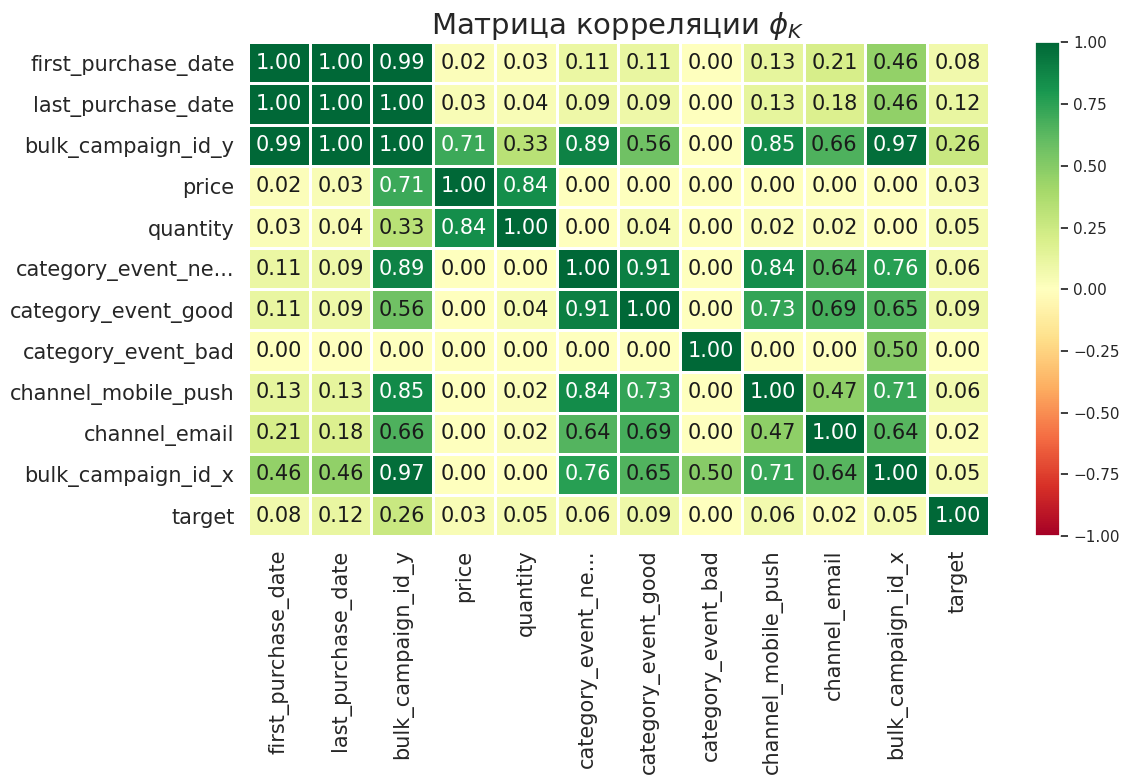

In [210]:
interval_cols_1 = ['channel_email',
                   'channel_mobile_push',
                   'category_event_bad',
                   'category_event_good',
                   'category_event_neutral',
                   'quantity',
                   'price',
                   'last_purchase_date',
                   'first_purchase_date']

phik_overview_1 = full_df[[ 'target',
                            'bulk_campaign_id_x',
                            'channel_email',
                            'channel_mobile_push',
                            'category_event_bad',
                            'category_event_good',
                            'category_event_neutral',
                            'quantity',
                            'price',
                            'bulk_campaign_id_y',
                            'last_purchase_date',
                            'first_purchase_date'
                        ]].phik_matrix(interval_cols=interval_cols_1)

plot_correlation_matrix(
    phik_overview_1.values,
    x_labels=phik_overview_1.columns,
    y_labels=phik_overview_1.index,
    title=r"Матрица корреляции $\phi_K$",
    fontsize_factor=1.5,
    figsize=(12, 8)
)

Лучше всего целевой признак `target` коррелирует с `bulk_campaign_id_y`, `category_event_good` и `last_purchase_date`. С признаками `category_event_bad`, `channel_email` корреляция почти отсутствует.

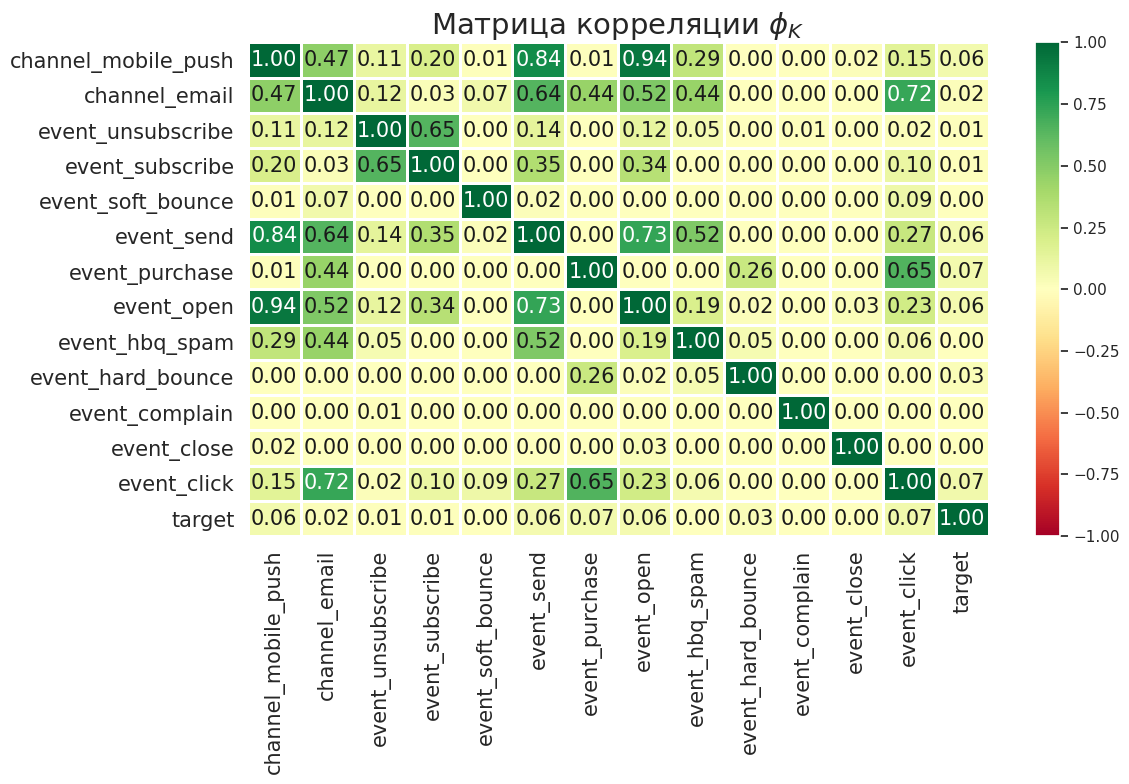

In [211]:
interval_cols_2 = ['event_click',
                   'event_close',
                   'event_complain',
                   'event_hard_bounce',
                   'event_hbq_spam',
                   'event_open',
                   'event_purchase',
                   'event_send',
                   'event_soft_bounce',
                   'event_subscribe',
                   'event_unsubscribe',
                   'channel_email',
                   'channel_mobile_push'
                   ]

phik_overview_2 = full_df[[ 'target',
                            'event_click',
                            'event_close',
                            'event_complain',
                            'event_hard_bounce',
                            'event_hbq_spam',
                            'event_open',
                            'event_purchase',
                            'event_send',
                            'event_soft_bounce',
                            'event_subscribe',
                            'event_unsubscribe',
                            'channel_email',
                            'channel_mobile_push'
                        ]].phik_matrix(interval_cols=interval_cols_2)

plot_correlation_matrix(
    phik_overview_2.values,
    x_labels=phik_overview_2.columns,
    y_labels=phik_overview_2.index,
    title=r"Матрица корреляции $\phi_K$",
    fontsize_factor=1.5,
    figsize=(12, 8)
)

Корреляция целевого признака присутствует только с признаками `event_purchase`, `event_click`, `event_send`, `event_open` и `channel_mobile_push` остальные можно удалить.

Оставим в таблице только полезные признаки.

In [212]:
data = full_df[['client_id',
               'target',
               'event_click',
               'event_open',
               'event_purchase',
               'channel_mobile_push',
               'category_event_good',
               'quantity',
               'price',
               'bulk_campaign_id_y',
               'last_purchase_date'
               ]]

Построим итоговую матрицу корреляции.

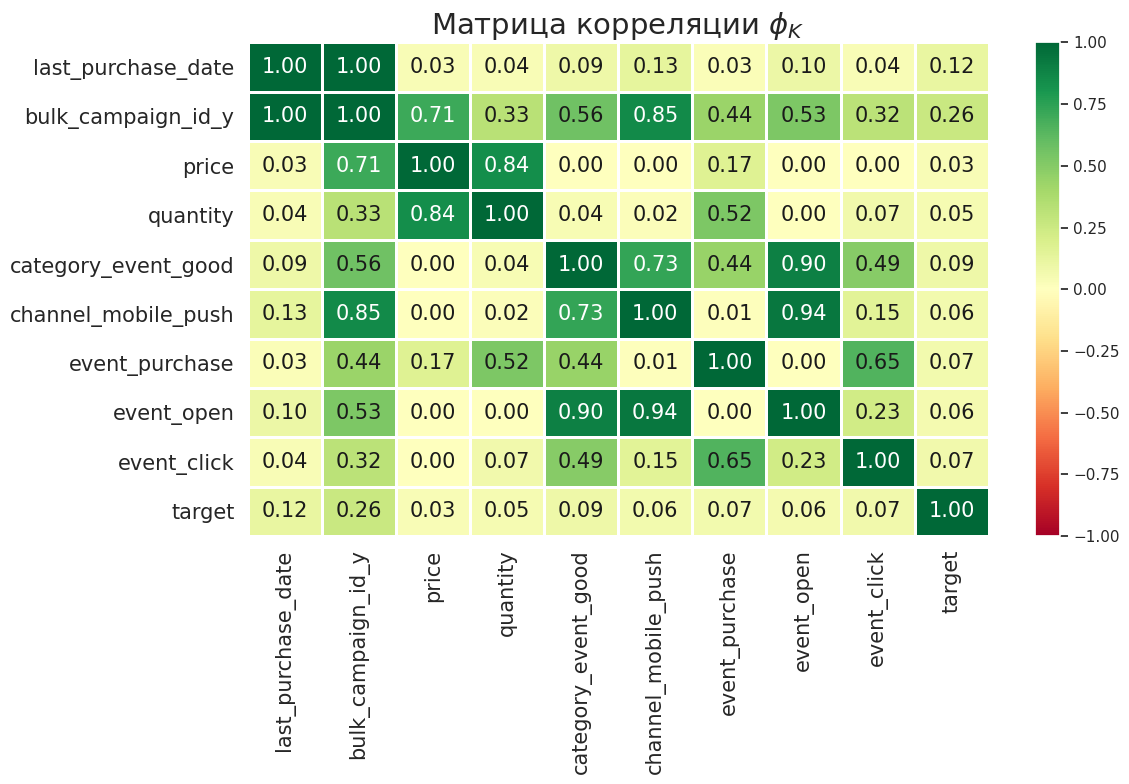

In [213]:
interval_cols = data.drop(['client_id',
                           'bulk_campaign_id_y'
                          ], axis=1).columns.tolist()

phik_overview = data.drop(['client_id',], axis=1).phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"Матрица корреляции $\phi_K$",
    fontsize_factor=1.5,
    figsize=(12, 8)
)

На матрице корреляции лучше всего себя показывает признак `bulk_campaing_id_y` - это компания по которой была совершена последняя покупка.

#### Выводы:

Лучше всего целевой признак `target` коррелирует с `bulk_campaign_id_y`, `category_event_good` и `last_purchase_date`. С признаками `category_event_bad`, `channel_email` корреляция почти отсутствует.

Корреляция целевого признака присутствует с признаками `event_purchase`, `event_click`, `event_send`, `event_open` и `channel_mobile_push` остальные можно удалить.

После удаления лишних признаков на матрице корреляции лучше всего себя показывает признак `bulk_campaing_id_y` - это компания по которой была совершена последняя покупка.

### Подготовка данных.

Поделим данные на тренировочную и тестовую выборку.

In [214]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['client_id','target'], axis=1),
    data['target'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify=data['target']
)

Создадим списки с названиями признаков.

In [215]:
num_columns = X_train.drop(['bulk_campaign_id_y'], axis=1).select_dtypes(include='number').columns.tolist()
ord_columns = ['bulk_campaign_id_y']

Собираем пайплайн.

In [216]:
# добавляем ord кодирование
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-999)
        ),
        (
            'ord',
            OrdinalEncoder(
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-999)
        )
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

### Поиск лучшей модели.

#### RandomizedSearchCV.

Для поиска лучшей модели и гиперпараметров воспользуемся RandomizedSearchCV. Рассмотрим несколько моделей:

- `DecisionTreeClassifier`
- `KNeighborsClassifier`
- `LogisticRegression`
- `SVC`

In [217]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 31),
        'models__max_features': range(2, 31),
        'models__min_samples_split': range(1, 15),
        'models__min_samples_leaf': range(1, 15),
        'preprocessor__num': [StandardScaler()]
    },

    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 50),
        'preprocessor__num': [StandardScaler()]
    },

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='saga',
            penalty='l1'
        )],
        'models__C': [0.01, 0.1, 1, 2, 3, 4, 5],
        'preprocessor__num': [StandardScaler()]
    },

    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel' : ['rbf', 'sigmoid'],
        'models__C': [0.01, 0.1, 1, 2, 3, 4, 5, 6],
        'models__gamma': [0.01, 0.1, 1],
        'preprocessor__num': [StandardScaler()]
    }
]

In [218]:
rand_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    n_iter=100
)

In [219]:
rand_search.fit(X_train, y_train);

In [220]:
print('Лучшая модель и её параметры:\n\n', rand_search.best_params_)

Лучшая модель и её параметры:

 {'preprocessor__num': StandardScaler(), 'models__min_samples_split': 11, 'models__min_samples_leaf': 9, 'models__max_features': 30, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=42)}


In [221]:
y_pred = rand_search.predict_proba(X_test)[:,1]
print('Метрика ROC-AUC на кросс-валидации:', rand_search.best_score_)
print('Метрика ROC-AUC на тестовой выборке:', roc_auc_score(y_test, y_pred))

Метрика ROC-AUC на кросс-валидации: 0.6830255058615518
Метрика ROC-AUC на тестовой выборке: 0.7016487019007881


#### RandomForestClassifier.

Применим OptunaSearchCV для поиска личших параметров модели RandomForestClassifier.

In [222]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final_forest = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', RandomForestClassifier(random_state=RANDOM_STATE))
])

parameters_forest = {
    'models__max_depth': distributions.IntDistribution(2, 35),
    'models__min_samples_split': distributions.IntDistribution(2, 30),
    'models__max_features': distributions.IntDistribution(1, 20),
    'models__min_samples_leaf': distributions.IntDistribution(1, 20),
}

oscv_forest = OptunaSearchCV(
    pipe_final_forest,
    parameters_forest,
    scoring='roc_auc',
    cv=5,
    n_trials=5,
    random_state=RANDOM_STATE
)

In [223]:
oscv_forest.fit(X_train, y_train);

[I 2024-09-29 13:49:16,717] A new study created in memory with name: no-name-89834ebb-cf8f-4844-9b5b-16de40d54e83
[I 2024-09-29 13:49:45,272] Trial 0 finished with value: 0.7085719374391626 and parameters: {'models__max_depth': 17, 'models__min_samples_split': 26, 'models__max_features': 2, 'models__min_samples_leaf': 7}. Best is trial 0 with value: 0.7085719374391626.
[I 2024-09-29 13:50:42,276] Trial 1 finished with value: 0.6849117488621478 and parameters: {'models__max_depth': 18, 'models__min_samples_split': 10, 'models__max_features': 5, 'models__min_samples_leaf': 4}. Best is trial 0 with value: 0.7085719374391626.
[I 2024-09-29 13:51:22,915] Trial 2 finished with value: 0.7251455832893136 and parameters: {'models__max_depth': 7, 'models__min_samples_split': 11, 'models__max_features': 7, 'models__min_samples_leaf': 20}. Best is trial 2 with value: 0.7251455832893136.
[I 2024-09-29 13:52:44,768] Trial 3 finished with value: 0.6973864205165021 and parameters: {'models__max_depth'

Выведем лучшие параметры модели на экран.

In [224]:
oscv_forest.best_params_

{'models__max_depth': 7,
 'models__min_samples_split': 11,
 'models__max_features': 7,
 'models__min_samples_leaf': 20}

In [225]:
y_pred_forest = oscv_forest.predict_proba(X_test)[:,1]
print('Метрика ROC-AUC модели на кросс-валидации:', oscv_forest.best_score_)
print('Метрика ROC-AUC модели на тестовой выборке:', roc_auc_score(y_test, y_pred_forest))

Метрика ROC-AUC модели на кросс-валидации: 0.7251455832893136
Метрика ROC-AUC модели на тестовой выборке: 0.7350096471133656


#### CatBoostClassifier.

Зададим параметры для модели CatBoostClassifier.

In [226]:
# обозначим входные и целевой признаки
X = data.drop(columns=['client_id', 'target'])
y = data['target']

# разделим данные на обучающую и тестовую выборки
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y
    )

# зададим категориальные столбцы
cat_features = ['bulk_campaign_id_y']

# настроим тренировочную и тестовую выборки
train_dataset = Pool(X_train_cat, y_train_cat, cat_features=cat_features)
test_dataset = Pool(X_test_cat, y_test_cat, cat_features=cat_features)

# создадим модель
model = CatBoostClassifier(
    learning_rate=0.1,
    iterations=200,
    use_best_model=True,
    eval_metric="AUC",
    loss_function="Logloss",
    early_stopping_rounds=20,
    verbose=False,
    random_state=RANDOM_STATE
)

In [227]:
model.fit(train_dataset, eval_set=test_dataset)

In [228]:
cv_data = train_dataset
cv_scores_cat = cv(
    cv_data,
    model.get_params(),
    fold_count=5,
    plot=True,
    shuffle=True,
    logging_level="Silent",
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [229]:
y_pred_cat = model.predict_proba(X_test)[:,1]
print('Метрика ROC-AUC на кросс-валидации:', cv_scores_cat['test-AUC-mean'].values[-1])
print('Метрика ROC-AUC на тестовой выборке:', roc_auc_score(y_test, y_pred_cat))

Метрика ROC-AUC на кросс-валидации: 0.7322592811167488
Метрика ROC-AUC на тестовой выборке: 0.7455447721508631


#### Выводы:

In [230]:
print('Модель DecisionTreeClassifier:')
print('- метрика ROC-AUC на кросс-валидации:', rand_search.best_score_)
print('- метрика ROC-AUC на тестовой выборке:', roc_auc_score(y_test, y_pred))

print('\nМодель RandomForestClassifier:')
print('- метрика ROC-AUC на кросс-валидации:', oscv_forest.best_score_)
print('- метрика ROC-AUC на тестовой выборке:', roc_auc_score(y_test, y_pred_forest))

print('\nМодель CatBoostClassifier:')
print('- метрика ROC-AUC на кросс-валидации:', cv_scores_cat['test-AUC-mean'].values[-1])
print('- метрика ROC-AUC на тестовой выборке:', roc_auc_score(y_test, y_pred_cat))

Модель DecisionTreeClassifier:
- метрика ROC-AUC на кросс-валидации: 0.6830255058615518
- метрика ROC-AUC на тестовой выборке: 0.7016487019007881

Модель RandomForestClassifier:
- метрика ROC-AUC на кросс-валидации: 0.7251455832893136
- метрика ROC-AUC на тестовой выборке: 0.7350096471133656

Модель CatBoostClassifier:
- метрика ROC-AUC на кросс-валидации: 0.7322592811167488
- метрика ROC-AUC на тестовой выборке: 0.7455447721508631


Наилучший результат показала модель CatBoostClassifier.

### Анализ важности признаков.

In [231]:
# создаём объясняющий объект explainer
explainer = shap.TreeExplainer(model)

# получаем значения Шепли
shap_values = explainer(X_test_cat)

Построим график важности признаков.

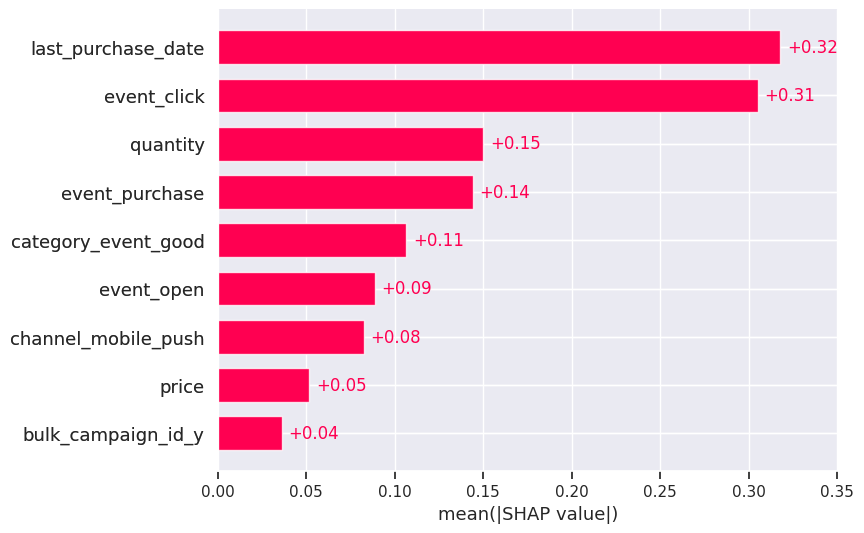

In [232]:
shap.plots.bar(shap_values)

Наиболее важными признаками оказались:
- `last_purchase_date` - количество прошедший дней от последней покупки
- `event_click` - клик по сообщению
- `quantity` - количество купленных товаров
- `event_purchase` - покупка товара из рассылки
- `category_event_good` - признак, который содержит данные о хороших активностях (клик, открытие сообщения, покупка)

### Выводы.

Целью данного исследования являлось построение модели МО для определения будущей активности клиентов: совершит клинет покупку в течении 90 дней или нет. Для достижения данной цели нам было предаставленно несколько датасетов с данными о покупках клиента и маркетиноговой активности.

**Обзор данных**.

Таблица `purchases` содержит данные о покупках клиентов по дням и по товарам. В таблице 202,208 строки и 6 столбцов. Пропущенных значений нет.

Таблица `messages` содержит данные о рассылках, которые были отправлены клиентам из таблицы покупок. Пропущенных значений нет. В таблице 12,739,798 строк и 7 столбцов.

Таблица `target` содержит целевой признак - совершит ли клиент покупку в течение следующих 90 дней. Пропущенных значений нет. В таблице 49,849 строк.

Таблица `daily_event` содержит агрегацию общей базы рассылок по дням и типам событий. Пропущенных значений нет. В таблице 131,072 строк и 24 столбца.

Таблица `daily_event_channel` содержит агрегацию по дням с учетом событий и каналов рассылки. Пропущенных значений нет. В таблице 131,072 строк и 36 столбцов.

**Предобработка данных.**

Типы данных в столбцах были приведены в соответствии с их содержимым.

Проверены явные и неявные дубликаты.

При проверке количественных признаков явных выбросов не обнаружено, минимальное количество товаров - 1, максимальное - 30, минимальная цена - 1, максимальная 85.499. Данные о чеках доступны почти за два года с 2022-05-16 по 2024-02-16.

**Исследовательский анализ данных.**

- Таблица `purchases`

Большинство покупок было совершено в количестве 1 штуки. Размах значений от 1 до 30. Из 202,208 записей всего 885 покупок с количеством товара более одного.

Размах значений цен от 1 до 85,499. Суммы заказов в основном небольшие, примерно до 4,000. На гистограмме мы видим нормально распределение с отклонением вправо. Есть пиковые значения из разряда 99, 999, 1999 и так далее, что вполне нормально при выставлении более привлекательной цены для покупателя. Удалим выбросы с ценой более 5,000.

Большинство позиций в чеках содержат категории: 4, 28.

На графике с датами продаж мы обнаружили, что продажи непостоянны, есть большое количество продаж в летний период 06.2022 и 06.2023. В зимний период 11.2022 и 12.2022 был рост продаж, однако, в те же месяцы 2023 года продажы были значительно ниже.

- Таблица `messages`

На графике маркетинговой активности мы видим большое количество отправленных писем, более 9,000,000. Было открыто более 3,000,000. Перешли по ссылке более 480,000. Совершили покупку более 62,000. Можно сделать несколько категорий из данных признаков - "хорошую" с письмами, которые открыли, кликнули и совершили покупку, нейтральную категорию с письмами без действий, то есть которые просто отправили, и "плохую" категорию со всеми оставшимися категориями.

Чаще сообщения отправляются с помощью пуш уведомлений.

Количество рассылок сообщений по датам распределены равномерно. Есть небольшой рост отправки сообщений в конце года в 11 и 12 месяце.

- Таблица `target`

Был обнаружен дисбаланс классов, 98% данных с признаком 0, 2% с признаком 1. Можно будет применить оверсэмплер.

**Объединение таблиц и новые признаки.**

Были объедены таблицы с данными о покупках, с данными о маркетиноговой активности и добавлен целевой признак.

Были созданы новые признаки `last_purchase_date` и `first_purchase_date` с данными клиента о первой и последней покупке.

В новый признак `category_event`, вошли значения:

- `good` - `open`, `click`, `purchase`, `subscribe`
- `bad` - `unsubscribe`, `complain`
- `neutral` - `send`, `hard_bounce`, `soft_bounce`, `hbq_spam`, `unknown`, `close`

**Корреляционный анализ.**

Лучше всего целевой признак `target` коррелирует с `bulk_campaign_id_y`, `category_event_good` и `last_purchase_date`. С признаками `category_event_bad`, `channel_email` корреляция почти отсутствует.

Корреляция целевого признака присутствует с признаками `event_purchase`, `event_click`, `event_send`, `event_open` и `channel_mobile_push` остальные можно удалить.

После удаления лишних признаков на матрице корреляции лучше всего себя показывает признак `bulk_campaing_id_y` - это компания по которой была совершена последняя покупка.

**Подготовка данных.**

Данные были разбиты на тренировочную и тестовую выборки. Написан пайплайн с кодировщиками.

**Обучение моделей.**

**RandomizedSearchCV**

Для поиска лучшей модели и гиперпараметров был использован RandomizedSearchCV. Рассмотрены несколько моделей:

- `DecisionTreeClassifier`
- `KNeighborsClassifier`
- `LogisticRegression`
- `SVC`

Лучше всего себя показала модель `DecisionTreeClassifier` с параметрами:

- `min_samples_split=11`
- `min_samples_leaf=9`
- `max_features=30`
- `max_depth=5`

Метрика ROC-AUC на кросс-валидации: 0.68

**RandomForestClassifier**

Для поиска личших параметров модели RandomForestClassifier был использован OptunaSearchCV.

Получившиеся параметры:

- `max_depth=7`
- `min_samples_split=11`
- `max_features=7`
- `min_samples_leaf=20`

Метрика ROC-AUC на кросс-валидации: 0.72

**CatBoostClassifier**

Была построена модель с параметрами:

- `learning_rate=0.1`
- `iterations=200`
- `use_best_model=True`
- `eval_metric="AUC"`
- `loss_function="Logloss"`
- `early_stopping_rounds=20`
- `verbose=False`

Метрика ROC-AUC на кросс-валидации: 0.73

**Выбор лучшей модели.**

Модель `DecisionTreeClassifier`:
- метрика ROC-AUC на кросс-валидации: 0.68
- метрика ROC-AUC на тестовой выборке: 0.70

Модель `RandomForestClassifier`:
- метрика ROC-AUC на кросс-валидации: 0.72
- метрика ROC-AUC на тестовой выборке: 0.73

Модель `CatBoostClassifier`:
- метрика ROC-AUC на кросс-валидации: 0.73
- метрика ROC-AUC на тестовой выборке: 0.74


Наилучший результат показала модель `CatBoostClassifier`.

**Анализ важности признаков.**

Наиболее важными признаками оказались:
- `last_purchase_date` - количество прошедший дней от последней покупки
- `event_click` - клик по сообщению
- `quantity` - количество купленных товаров
- `event_purchase` - покупка товара из рассылки
- `category_event_good` - признак, который содержит данные о хороших активностях (клик, открытие сообщения, покупка)

**Рекомендации.**

Для улучшения качества модели стоит изучить таблицы `full_campaign_daily_event` и `full_campaign_daily_event_channel`, найти наиболее успешные компании и формы коммуникации и использовать их для создания новых признаков.

Стоит обратить внимание, что один из самых важных признаков - временной. Возможно, создание новых временных признаков улучшит качество предсказания.